In [195]:
import torch
import numpy as np

In [196]:
plt.rc('figure', dpi=90)

def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, steps=200, ylim=None, color='r'):
    x = torch.linspace(min,max, steps=steps)[:,None]
    plt.plot(x,f(x),color)
    if tx is not None: plt.xlabel(tx)
    if ty is not None: plt.ylabel(ty)
    if title is not None: plt.title(title)
    if ylim: plt.ylim(ylim)
    plt.grid()

## Fitting a function to observations
Simple quadratic function:

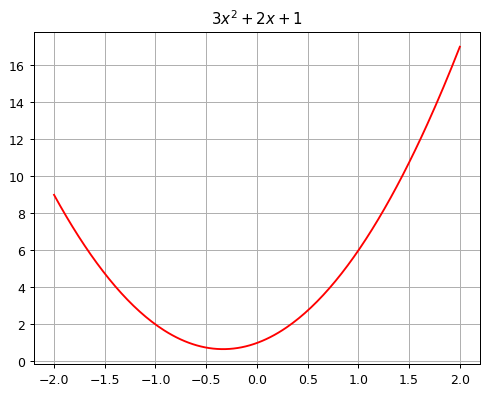

In [197]:
def f(x): return 3*x**2 + 2*x + 1
plot_function(f, title="$3x^2 + 2x + 1$")

We can create a general quadratic form, and then instantiate quadratic functions using `partial`:

In [198]:
def quad(a,b,c,x): return a*x**2 + b*x + c

from functools import partial
def make_quad(a,b,c): return partial(quad, a,b,c)

For example:

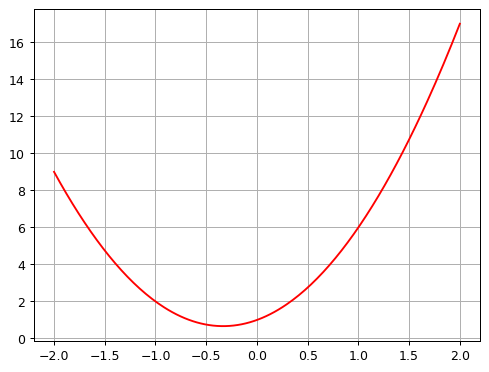

In [199]:
f2 = make_quad(3,2,1)
plot_function(f2)

A nice way is to use the `interact` decorator:

In [200]:
from ipywidgets import interact
@interact(a=1.1, b=1.1, c=1.1)
def plot_quad(a,b,c):
    plot_function(make_quad(a,b,c), ylim=(-5,20))

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

Now lets add some noise to a quadratic function and plot both, with and without noise:

In [201]:
def noise(x, scale): return np.random.normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x * (1 + noise(x,mult)) + noise(x,add)

In [202]:
np.random.seed(42)
x = torch.linspace(-2, 2, steps=20)[:,None]
y = add_noise(f(x), 0.15, 1.5)

In [203]:
x[:5],y[:5]

(tensor([[-2.0000],
         [-1.7895],
         [-1.5789],
         [-1.3684],
         [-1.1579]]),
 tensor([[11.8690],
         [ 6.5433],
         [ 5.9396],
         [ 2.6304],
         [ 1.7947]], dtype=torch.float64))

We are going to re-define `plot_quad` for the purpose of having a quadratic function plotted with and without noise

In [204]:
@interact(a=1.1, b=1.1, c=1.1)
def plot_quad(a, b, c):
    plt.scatter(x,y)
    plot_function(make_quad(a,b,c), ylim=(-3,12))

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

We can tweak the parameters `a`, `b`, and `c` to try find the quadratic function that best describes the dots. How can we tell if the function is good enough? What metrics can we use?

One common metric is the *mean absolute error*:

In [205]:
def mae(preds, acts): return (torch.abs(preds-acts).mean())

Now we can add the calculation of `mae` into the plot:

In [206]:
@interact(a=1.1, b=1.1, c=1.1)
def plot_quad(a, b, c):
    f = make_quad(a,b,c)
    plt.scatter(x,y)
    loss = mae(f(x),y)
    plot_function(f, ylim=(-3,12),title=f"MAE: {loss:.2f}")

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

## Automated Gradient Descent
### Gradient of `mae`

In [207]:
def quad_mae(params):
    f = make_quad(*params)
    return mae(f(x), y)

In [208]:
quad_mae([1.1,1.1,1.1])

tensor(2.4219, dtype=torch.float64)

First we create a tensor with value `1.1` in all its coordinates:

In [209]:
abc = torch.tensor([1.1,1.1,1.1])
abc

tensor([1.1000, 1.1000, 1.1000])

Now we tell `torch` that we want to compute the gradient of tensor `abc`:

In [210]:
abc.requires_grad_()

tensor([1.1000, 1.1000, 1.1000], requires_grad=True)

Now we can calculate the loss of `abc` and compute the gradient (using the function `backward()`):

In [211]:
loss = quad_mae(abc)
loss.backward()
loss

tensor(2.4219, dtype=torch.float64, grad_fn=<MeanBackward0>)

The gradient is stored in the attribute `grad` of `abc`: (I know, it is a little weird that the gradient of a function is stored in the parameters that evaluate that function)

In [212]:
abc.grad

tensor([-1.3529, -0.0316, -0.5000])

Now we update the value of parameters `abc` using the gradient we just got multiplied by a *learning rate* of `0.01`

In [213]:
with torch.no_grad():
    abc -= abc.grad*0.01
    loss = quad_mae(abc)

print(f"loss = {loss:.2f}")

loss = 2.40


Now lets make this search automatic:

In [214]:
learn_rate = 0.01
for i in range(1,100):
    loss = quad_mae(abc)
    if loss < 0.01: break
    loss.backward()
    with torch.no_grad(): abc -= abc.grad*learn_rate
    print(f"step={i}; loss={loss:.2f}")

step=1; loss=2.40
step=2; loss=2.36
step=3; loss=2.30
step=4; loss=2.21
step=5; loss=2.11
step=6; loss=1.98
step=7; loss=1.85
step=8; loss=1.72
step=9; loss=1.58
step=10; loss=1.46
step=11; loss=1.35
step=12; loss=1.22
step=13; loss=1.17
step=14; loss=1.17
step=15; loss=1.26
step=16; loss=1.40
step=17; loss=1.55
step=18; loss=1.70
step=19; loss=1.83
step=20; loss=1.95
step=21; loss=2.06
step=22; loss=2.16
step=23; loss=2.23
step=24; loss=2.28
step=25; loss=2.29
step=26; loss=2.27
step=27; loss=2.22
step=28; loss=2.14
step=29; loss=2.04
step=30; loss=1.90
step=31; loss=1.78
step=32; loss=1.66
step=33; loss=1.53
step=34; loss=1.40
step=35; loss=1.26
step=36; loss=1.16
step=37; loss=1.11
step=38; loss=1.08
step=39; loss=1.07
step=40; loss=1.16
step=41; loss=1.30
step=42; loss=1.48
step=43; loss=1.68
step=44; loss=1.85
step=45; loss=2.00
step=46; loss=2.13
step=47; loss=2.24
step=48; loss=2.31
step=49; loss=2.35
step=50; loss=2.37
step=51; loss=2.36
step=52; loss=2.32
step=53; loss=2.25
st